In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
import copy

import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as optimize

sys.path.insert(0, '/Users/lackey/Research/cbcrom')
import cbcrom.timedomainwaveform as tdwave
import cbcrom.timedomainrom as tdrom

Populating the interactive namespace from numpy and matplotlib


__init__: Setting weave cache to /var/folders/zl/bw0yy2l15g339xpfq2gmxh7c0000gn/T/501_python27_compiled/1.6.2/


In [2]:
# Modules for generating waveforms
import lalsimulation # Get waveform functions
import lal # Get constants
import pycbc.types # TimeSeries
import pycbc.waveform # Waveforms

In [3]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%perl  %%prun  %%pypy  %%python  %%python2  %%python3

In [6]:
%who

blah	 copy	 integrate	 interpolate	 lal	 lalsimulation	 optimize	 pycbc	 tdrom	 
tdwave	 


In [7]:
pyplot.rcParams.update({
    'figure.figsize': (8, 6),    # figure size in inches
    'text.usetex': True,
#     "font.family": 'serif',
#     "font.serif": ['Computer Modern'],
    'font.size': 14,
    #'axes.titlesize': 20,
    'axes.labelsize': 20,
    'axes.linewidth': 2,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 14,
    'xtick.major.size': 8,
    'xtick.minor.size': 4, 
    'xtick.major.width': 2,
    'xtick.minor.width': 2,
    'xtick.direction': 'out',
    'ytick.major.size': 8,
    'ytick.minor.size': 4, 
    'ytick.major.width': 2,
    'ytick.minor.width': 2,
    'ytick.direction': 'out',  
    'axes.prop_cycle'    : cycler('color', 'bgrcmyk'),
    })

class MinorSymLogLocator(Locator):
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """
    def __init__(self, linthresh):
        """
        Ticks will be placed between the major ticks.
        The placement is linear for x between -linthresh and linthresh,
        otherwise its logarithmically
        """
        self.linthresh = linthresh

    def __call__(self):
        'Return the locations of the ticks'
        majorlocs = self.axis.get_majorticklocs()

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in xrange(1, len(majorlocs)):
            majorstep = majorlocs[i] - majorlocs[i-1]
            if abs(majorlocs[i-1] + majorstep/2) < self.linthresh:
                ndivs = 10
            else:
                ndivs = 9
            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i-1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError('Cannot get tick locations for a '
                                  '%s type.' % type(self))

# Waveform class

In [4]:
def complex_to_amp_phase(hcomplex):
    """Take a complex series and convert to amplitude and unwrapped phase.
    """
    # Calculate the amplitude
    amp = np.abs(hcomplex)
    
    # Calculate the angle (between -pi and pi)
    phase_wrapped = np.angle(hcomplex)
    
    # Unwrap the phase
    phase = np.unwrap(phase_wrapped)

    return amp, phase


class Waveform(object):
    """Generic class for either time-domain or frequency-domain waveforms.
    Can store (x, amp, phase), just (x, amp), just (x, phase), or custom set of data.
    """
    
    ######### Create class ##########
    def __init__(self, data):
        """Array with named columns. First column is 'x'. Or, use a dictionary to make
        a list of named 1d arrays.
        
        Parameters:
        ----------
        data : dictionary of equal length numpy arrays
        """
        # Make a copy of the dictionary *and* a copy of 
        # its contents with deepcopy (not a reference).
        self.data = copy.deepcopy(data)
    
    @classmethod
    def from_amp_phase(cls, x, amp, phase, remove_start_phase=False):
        """Create Waveform from (x, amp, phase) data.        
        """
        data = {'x': x, 'amp': amp, 'phase': phase}
        h = Waveform(data)
        # Zero the start phase if requested
        if remove_start_phase:
            h.add_phase(remove_start_phase=remove_start_phase)
        return h

    @classmethod
    def from_complex(cls, x, hcomplex, remove_start_phase=False):
        """Create Waveform from (x, hcomplex) data.        
        """
        amp, phase = complex_to_amp_phase(hcomplex)
        return cls.from_amp_phase(x, amp, phase, remove_start_phase=remove_start_phase)
    
    @classmethod
    def from_hp_hc(cls, x, hplus, hcross, remove_start_phase=False):
        """Create Waveform from (x, hp+ihc) data.        
        """
        hcomplex = hplus+1.0j*hcross
        return cls.from_complex(x, hcomplex, remove_start_phase=remove_start_phase)
    
    @classmethod
    def from_array(cls, x, y, yname='y'):
        """Create Waveform from (x, y) data.        
        """
        data = {'x': x, yname: y}
        return cls(data)
    
    ### Getters and setters for most common arrays: x, amp, phase ###
    
    @property
    def x(self):
        """Can call this with h.x"""
        return self.data['x']
    
    @x.setter
    def x(self, xarr):
        self.data['x'] = xarr
        
    @property
    def amp(self):
        return self.data['amp']
    
    @amp.setter
    def amp(self, amparr):
        self.data['amp'] = amparr
    
    @property
    def phase(self):
        return self.data['phase']
    
    @phase.setter
    def phase(self, phasearr):
        self.data['phase'] = phasearr
    
    ########## copy Waveform ########
    def copy(self):
        """Copy the Waveform so you don't overwrite the original.
        """
        return Waveform(self.data)
    
    ########## Inserting data #########
    def add_data(self, y, yname='y'):
        """Add the array y to the data dictionary.
        """
        self.data[yname] = np.copy(y)
    
    ######## Shifting x and phase ########
    def add_x(self, x):
        """Add x to the 'x' data.
        """
        self.data['x'] += x
        
    def add_phase(self, phi=None, remove_start_phase=False):
        """Add phi to the phase,
        or zero the phase at the start.
        """
        # Add the phase add_phase
        if phi is not None:
            self.data['phase'] += phi
        # Shift the phase to be 0.0 at the first data point
        if remove_start_phase:
            self.data['phase'] += -self.data['phase'][0]
    
    ############# Interpolating data ##############
    def interpolate(self, yname, order=2):
        """Interpolate y(x) with polynomial of order order.
        """
        return interpolate.UnivariateSpline(self.data['x'], self.data[yname], k=order, s=0)
    
    def interpolate_complex(self, order=2, ampname='amp', phasename='phase'):
        """Interpolate complex waveform by interpolating amp(x) and phase(x).
        """
        ampoft = self.interpolate(ampname, order=order)
        phaseoft = self.interpolate(phasename, order=order)
        def comp(t):
            return ampoft(t)*np.exp(1.0j*phaseoft(t))
        return comp
    
    ########### Resampling data ############
    

In [177]:
def subtract_waveform_phase(h1, h2, npoints=1000):
    """Evaluate Phi_1(x) - Phi_2(x).
    
    Parameters
    ----------
    h1, h2 : Waveform
    npoints : int, optional
        Number of evenly spaced points at which to evaluate phase difference
        
    Returns
    -------
    Waveform object with fields 'x' and 'phase'
    """
    # Bounds [xi, xf] are the minimum and maximum values of x the two waveforms have in common.
    xi = max(h1.x[0], h2.x[0])
    xf = min(h1.x[-1], h2.x[-1])
    xs = np.linspace(xi, xf, npoints)
    
    h1phaseint = h1.interpolate('phase')
    h2phaseint = h2.interpolate('phase')
    
    phase1 = h1phaseint(xs)
    phase2 = h2phaseint(xs)
    return Waveform({'x': xs, 'phase': phase1-phase2})

# Functions for constructing hybrid

In [5]:
def convolution(ampoft1, phaseoft1, ampoft2, phaseoft2, ti, tf, tau=0.0):
    """Calculate the convolution z(tau) = \int_ti^tf h1(t) h2^*(t-\tau) dt.
    It has the real and imaginary parts z(tau) = x(tau) + y(tau).
    """
    def real_part(t):
        return ampoft1(t)*ampoft2(t-tau)*(np.cos(phaseoft1(t)-phaseoft2(t-tau)))
    
    def imag_part(t):
        return ampoft1(t)*ampoft2(t-tau)*(np.sin(phaseoft1(t)-phaseoft2(t-tau)))
    
    x = integrate.quad(real_part, ti, tf)[0]
    y = integrate.quad(imag_part, ti, tf)[0]
    return x + 1.0j*y


def sigma(ampoft, ti, tf, tau=0.0):
    """Normalization constant for waveform in interval [ti, tf].
    (Optionally time shift the signal from t -> t-tau,
    to calculate normalization constant between ti-tau and tf-tau.)
    """
    # tprime = t - tau
    # dtprime = dt
    tprimei = ti - tau
    tprimef = tf - tau
    return np.sqrt(integrate.quad(ampoft, tprimei, tprimef)[0])


def overlap(ampoft1, phaseoft1, ampoft2, phaseoft2, ti, tf, tau=0.0):
    """The complex overlap between h1 and h2 in the time interval [ti, tf].
    h2 is shifted from t -> t-tau
    """
    z = convolution(ampoft1, phaseoft1, ampoft2, phaseoft2, ti, tf, tau)
    sigma1 = sigma(ampoft1, ti, tf)
    sigma2 = sigma(ampoft2, ti, tf, tau)
    
    return z/(sigma1*sigma2)

In [6]:
def calculate_time_phase_shift(h1, h2, t1i, t1f, taua, taub):
    """Find the time and phase shift for waveform 2 that maximizes the overlap between h1 and h2
    in the interval [t1i, t1f] for waveform 1.
    
    h1 stays fixed.
    h2 is shifted.
    """
    # Put error checking here:
    # Calculate minimum and maximum allowed time shifts.
    amp1int = h1.interpolate('amp')
    phase1int = h1.interpolate('phase')
    amp2int = h2.interpolate('amp')
    phase2int = h2.interpolate('phase')
    
    # Function to minimize
    def neg_overlap_amp(tau):
        """The function you are minimizing to find the best time shift.
        """
        return -np.abs(overlap(amp1int, phase1int, amp2int, phase2int, t1i, t1f, tau))
    
    # Search for minimum of neg_overlap_amp between taua and taub
    bounds = (taua, taub)
    overlapbest = optimize.minimize_scalar(neg_overlap_amp, bounds=bounds, method='bounded')
    
    # Time and phase shift needed for h2
    taubest = overlapbest.x
    comp_overlap_best = overlap(amp1int, phase1int, amp2int, phase2int, t1i, t1f, taubest)
    phibest = -np.angle(comp_overlap_best)
    
    return taubest, phibest

In [7]:
def construct_hybrid(h1, h2, wi, wf):
    """Take two waveforms that have already been aligned in time and phase
    and smoothly transition from h1 to h2 over the window [wi, wf].
    """
    # find times closest to boundaries w1, wf
    # convert data to complex
    # do window
    # convert back to complex
    
    def winoff(t):
        return 0.5*(1.0 + np.cos( (np.pi*(t-wi))/(wf-wi) ) )
    
    def winon(t):
        return 0.5*(1.0 - np.cos( (np.pi*(t-wi))/(wf-wi) ) )
    
    # searchsorted finds index of (sorted) time where point should be inserted,
    # pushing the later points to the right.
    # indices will be just to the right of the boundaries [wi, wf]:
    i1winstart = np.searchsorted(h1.data['x'], wi)
    i1winend = np.searchsorted(h1.data['x'], wf)
    i2winend = np.searchsorted(h2.data['x'], wf)
    
    # Times (before, in, after) hybridization window
    times1 = h1.data['x'][:i1winstart]
    times1hyb = h1.data['x'][i1winstart:i1winend]
    times2 = h2.data['x'][i2winend:]
    
    # Construct interpolating functions for the complex waveforms
    h1compint = h1.interpolate_complex()
    h2compint = h2.interpolate_complex()
    
    # Interpolate at the desired times, and do the windowing
    h1comp = h1compint(times1)
    hhybcomp = winoff(times1hyb)*h1compint(times1hyb)+winon(times1hyb)*h2compint(times1hyb)
    h2comp = h2compint(times2)
    
    # Join (before, during, after) the windowing
    times = np.concatenate((times1, times1hyb, times2))
    hcomp = np.concatenate((h1comp, hhybcomp, h2comp))
    
    # hybridized waveform
    return Waveform.from_hp_hc(times, np.real(hcomp), np.imag(hcomp))

In [8]:
def construct_inspiral_nr_hybrid(hinsp, hnr, tnrmatchi, tnrmatchf, tnrwini, tnrwinf):
    """
    Parameters
    ----------
    tnrmatchi : float
        Initial time of matching window from the maximum amplitude of the NR waveform.
    tnrmatchf : float
        Final time of matching window from the maximum amplitude of the NR waveform.
    """
    # What you should really do is start by shifting
    # both inspiral and NR to have t=0 at max amplitude (merger).
    # ...
    
    # Shift NR waveform time to be zero at max amplitude
    hnrshift = hnr.copy()
    nrmaxi = np.argmax(hnrshift.data['amp'])
    tnrmax = hnrshift.data['x'][nrmaxi]
    hnrshift.add_x(-tnrmax)
    
#     fig, axes = plt.subplots(1, figsize=(16, 6))
#     hplots = WaveformPlot(hinsp, hnrshift)
#     hplots.plot_waveforms(axes, -4000, 4000)
#     axes.minorticks_on()
    
    # Maximum and minimum times to search for best match
    shift_insp_min = tnrmatchf - hinsp.data['x'][-1]
    shift_insp_max = -tnrmatchi*2.0
    
#     print tnrmatchi, tnrmatchf
#     print shift_insp_min, shift_insp_max
    
    # Find time to shift inspiral waveform to match fixed NR waveform 
    taubest, phibest = calculate_time_phase_shift(hnrshift, hinsp, tnrmatchi, tnrmatchf, shift_insp_min, shift_insp_max)
    #print taubest, phibest
    
    # Now shift NR waveform (again) in the opposite direction
    hnrshift.add_x(-taubest)
    hnrshift.add_phase(phibest)
    
    # Make Construct the hybrid
    hhybrid = construct_hybrid(hinsp, hnrshift, tnrwini-taubest, tnrwinf-taubest)
    
    return hhybrid, hnrshift, taubest

In [9]:
# class WaveformPlot(object):
#     """Make class that takes Waveform object and makes various plots
#     """
#     def __init__(self, *args):
#         """Take variable number of waveforms.
#         """
#         self.waveforms = args
        
#     def plot_waveforms(self, axes, ti, tf):
#         axes.axhline(0.0, color='k', ls=':')
#         for h in self.waveforms:
#             tiplot = max(ti, h.data['x'][0])
#             tfplot = min(tf, h.data['x'][-1])
#             hcomp = h.interpolate_complex()
#             times = np.linspace(tiplot, tfplot, 1000)
#             hs = hcomp(times)
    
#             axes.plot(times, np.real(hs))
#             #axes.plot(times, np.imag(hs))
#             axes.plot(times, np.abs(hs))

In [10]:
def plot_waveforms(axes, waveforms, xi, xf, npoints=1000):
    axes.axhline(0.0, color='k', ls=':')
    
    for h in waveforms:
        xiplot = max(xi, h.x[0])
        xfplot = min(xf, h.x[-1])
        hcomp = h.interpolate_complex()
        times = np.linspace(xiplot, xfplot, npoints)
        hs = hcomp(times)
        
        axes.plot(times, np.real(hs))
        axes.plot(times, np.abs(hs))

# Convert between physical and dimensionless units

In [11]:
# Use the exact same units as LAL
G_SI = 6.67384e-11
C_SI = 299792458.0
MPC_SI = 3.085677581491367e+22
MSUN_SI = 1.9885469549614615e+30

def physical_to_dimensionless_time(hphys, mtot, dist):
    """Convert time-domain waveform from physical units of strain and time (s), 
    to dimensionless units rescaled by the total mass and distance.
    
    Parameters
    ----------
    hphys : Waveform
    mtot : Total mass of binary in solar masses
    dist : Distance in Mpc
    
    Returns
    -------
    hdim : Waveform
        Rescaled waveform with dimensionless units
    """
    hdim = hphys.copy()
    hdim.x *= C_SI**3 / (G_SI * MSUN_SI * mtot)
    hdim.amp *= C_SI**2 * MPC_SI * dist / (G_SI * MSUN_SI * mtot)
    return hdim
    
    
def dimensionless_to_physical_time(hdim, mtot, dist):
    hphys = hdim.copy()
    hphys.x *= G_SI * MSUN_SI * mtot / C_SI**3
    hphys.amp *= G_SI * MSUN_SI * mtot / (C_SI**2 * MPC_SI * dist)
    return hphys

    
def physical_to_dimensionless_freq(hphys, mtot, dist):
    hdim = hphys.copy()
    hdim.x *= G_SI * MSUN_SI * mtot / C_SI**3
    hdim.amp *= C_SI**5 * MPC_SI * dist / (G_SI * MSUN_SI * mtot)**2 
    return hdim
    
    
def dimensionless_to_physical_freq(hdim, mtot, dist):
    hphys = hdim.copy()
    hphys.x *= C_SI**3 / (G_SI * MSUN_SI * mtot)
    hphys.amp *= (G_SI * MSUN_SI * mtot)**2 / (C_SI**5 * MPC_SI * dist)
    return hphys

# Get ROM and NR waveforms

In [159]:
memb_size=2**26-1

Bamp_filename = '/Users/lackey/Research/cbcrom/data/Bamp_cheb_16_%d.hdf5'
Bphase_filename = '/Users/lackey/Research/cbcrom/data/Bphase_cheb_16_%d.hdf5'
ampcoeff_filename = '/Users/lackey/Research/cbcrom/data/amp_coeffs_cheb_16.hdf5'
phasecoeff_filename = '/Users/lackey/Research/cbcrom/data/phase_coeffs_cheb_16.hdf5'

rom = tdrom.load_reduced_order_model_time_domain_waveform(Bamp_filename, Bphase_filename, memb_size,
                                                  ampcoeff_filename, phasecoeff_filename)

def reduced_order_model_time_series(rom, **kwargs):
    """Convert ROM to pycbc TimeSeries.
    """
    tstart, delta_t, hp, hc = rom.evaluate_physical_units(**kwargs)
    hplus = pycbc.types.TimeSeries(hp, epoch=tstart, delta_t=delta_t)
    hcross = pycbc.types.TimeSeries(hc, epoch=tstart, delta_t=delta_t)
    return hplus, hcross

distance, inclination, f_lower, delta_t = 100.0, 0.0, 100.0, 1.0/2**14

mass1, mass2, lambda1, lambda2 = 1.0, 1.0, 607, 607
hromp, hromc = reduced_order_model_time_series(rom, mass1=mass1, mass2=mass2, lambda1=lambda1, lambda2=lambda2, 
                                        delta_t=delta_t, f_lower=f_lower, f_ref=None, 
                                        distance=distance, inclination=inclination, coa_phase=None)

hromphys = Waveform.from_hp_hc(np.array(hromp.sample_times), np.array(hromp), np.array(hromc))
hrom = physical_to_dimensionless_time(hromphys, mass1+mass2, distance)

In [160]:
waveformfiles=np.array([

[69, "B_135135_60.dat"], [72, "Bs_135135_60.dat"], [75, "Bss_135135_60.dat"],

[79, "HB_135135_60.dat"], [85, "HBss_135135_60.dat"],

[88, "H_135135_60.dat"], 
[91, "2H_135135_60.dat"]
])

directory = '/Users/lackey/Research/NRWaveform/BNSMergerShibata/'
#directory = '/home/bdlackey/NRWaveform/BNSMergerShibata/'

Nwaves = len(waveformfiles)
filenames = [directory + waveformfiles[i, 1] for i in range(Nwaves)]

# Get NR waveform
i=5
filename = filenames[i]
print(filename)
time, hp, hc = np.loadtxt(filename)[:, [0, 1, 2]].T
hnr = Waveform.from_hp_hc(time, hp, hc)

/Users/lackey/Research/NRWaveform/BNSMergerShibata/H_135135_60.dat


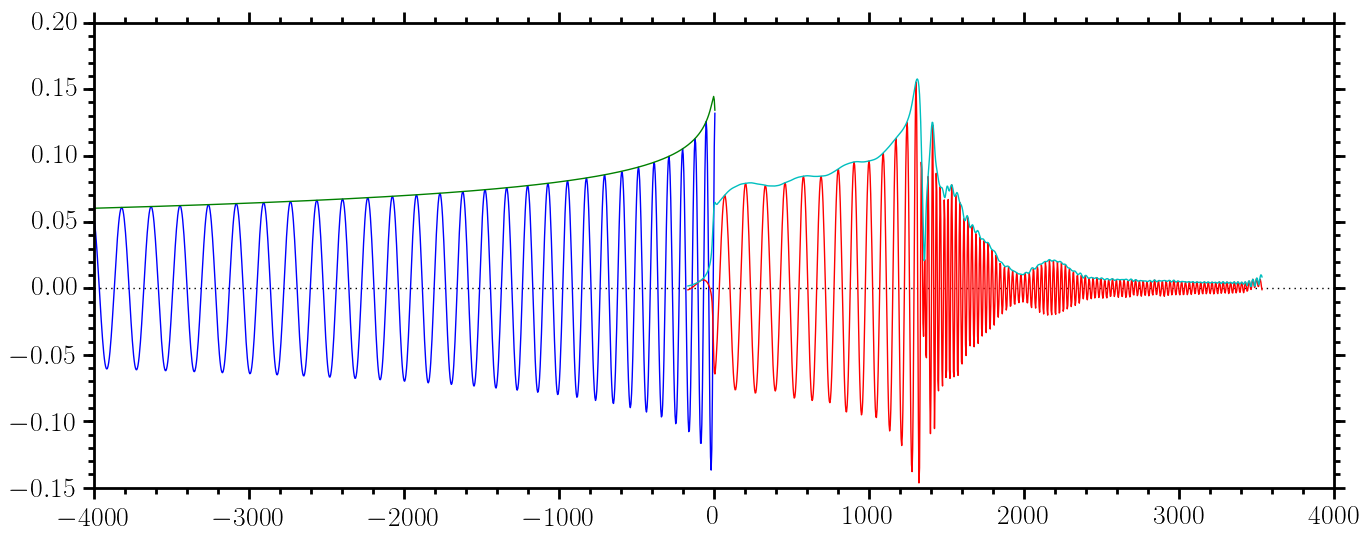

In [161]:
# Plot the waveforms
fig, axes = plt.subplots(1, figsize=(16, 6))
plot_waveforms(axes, [hrom, hnr], -4000, 4000)
axes.minorticks_on()

# Make hybrid waveform

In [162]:
tnrmatchi, tnrmatchf = -1000, -500
tnrwini, tnrwinf = tnrmatchi, tnrmatchi+250
hhybrid, hnrshift, taubest = construct_inspiral_nr_hybrid(hrom, hnr, tnrmatchi, tnrmatchf, tnrwini, tnrwinf)

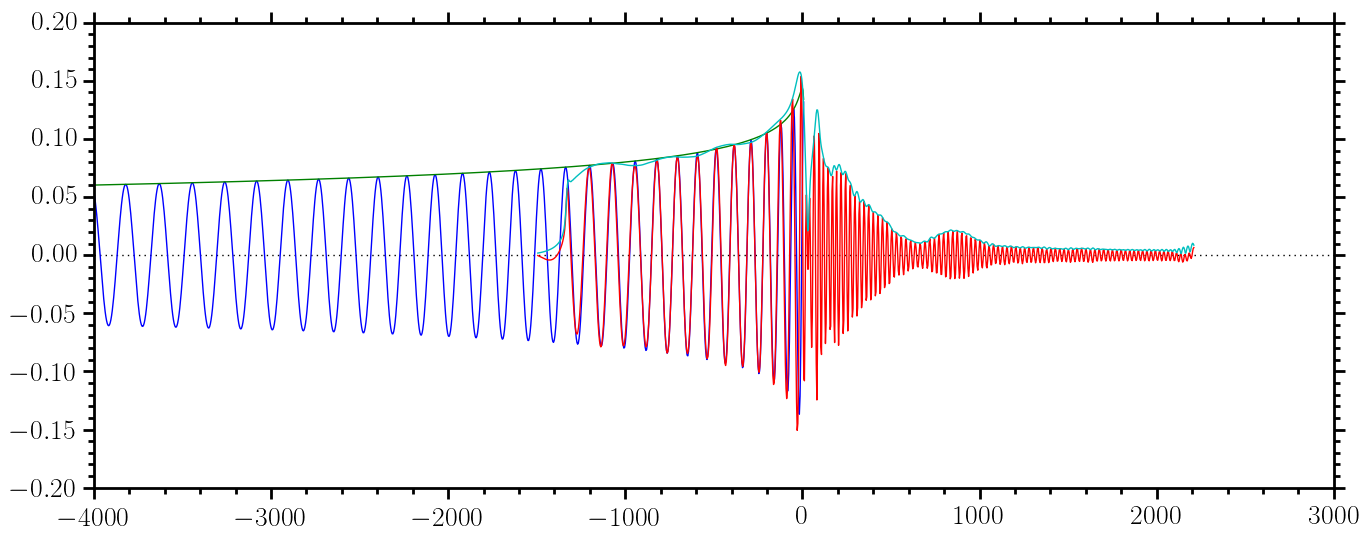

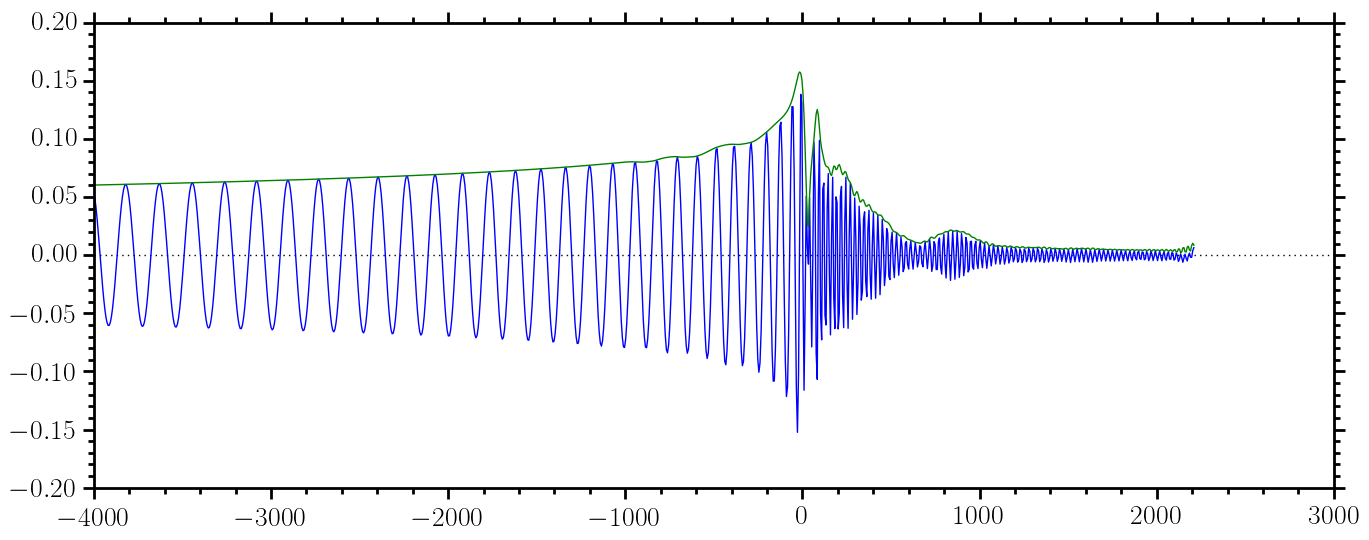

In [163]:
fig, axes = plt.subplots(1, figsize=(16, 6))
plot_waveforms(axes, [hrom, hnrshift], -4000, 4000)
axes.minorticks_on()

fig, axes = plt.subplots(1, figsize=(16, 6))
plot_waveforms(axes, [hhybrid], -4000, 4000)
axes.minorticks_on()

# Find best hybridization window

In [164]:
dmatch = 200
tnrmatchf_array1 = np.linspace(-1000, 0, 25)
tnrshift_list = []

for tnrmatchf in tnrmatchf_array1:
    tnrmatchi = tnrmatchf - dmatch

    tnrwini, tnrwinf = tnrmatchi, tnrmatchf

    hhybrid, hnrshift, tnrshift = construct_inspiral_nr_hybrid(hrom, hnr, tnrmatchi, tnrmatchf, tnrwini, tnrwinf)
    tnrshift_list.append(tnrshift)
    print tnrshift
    
tnrshift_array1 = np.array(tnrshift_list)

-139.860053327
-131.588225465


KeyboardInterrupt: 

In [ ]:
dmatch = 400
tnrmatchf_array2 = np.linspace(-1000, 0, 25) 
tnrshift_list = []

for tnrmatchf in tnrmatchf_array2:
    tnrmatchi = tnrmatchf - dmatch

    tnrwini, tnrwinf = tnrmatchi, tnrmatchf

    hhybrid, hnrshift, tnrshift = construct_inspiral_nr_hybrid(hrom, hnr, tnrmatchi, tnrmatchf, tnrwini, tnrwinf)
    tnrshift_list.append(tnrshift)
    print tnrshift
    
tnrshift_array2 = np.array(tnrshift_list)

In [ ]:
fig, axes = plt.subplots(1)
axes.plot(tnrmatchf_array1, tnrshift_array1, label=r'$\Delta t = 200M$')
axes.plot(tnrmatchf_array2[:-2], tnrshift_array2[:-2], label=r'$\Delta t = 400M$')
axes.set_xlabel(r'$t_{\rm NR final}$')
axes.set_ylabel(r'$t_{\rm NR shift}$')
axes.legend(loc='best')

# Fourier tansforms

In [265]:
distance, inclination, f_lower, delta_t = 100.0, 0.0, 100.0, 1.0/2**14
mass1, mass2, lambda1, lambda2 = 1.0, 1.0, 607, 607

#TaylorT4 waveform
ht4p, ht4c = pycbc.waveform.get_td_waveform(approximant='TaylorT4', 
                        mass1=mass1, mass2=mass2, lambda1=lambda1, lambda2=lambda2, 
                        distance=distance, inclination=inclination, 
                        delta_t=delta_t, f_lower=f_lower, f_ref=f_lower, 
                        phase_order=7, tidal_order=12, amplitude_order=6)
ht4p_tilde = ht4p.to_frequencyseries()
ht4c_tilde = ht4c.to_frequencyseries()

delta_f = ht4p_tilde.delta_f
hf2p_tilde, hf2c_tilde = pycbc.waveform.get_fd_waveform(approximant='TaylorF2', 
                        mass1=mass1, mass2=mass2, lambda1=lambda1, lambda2=lambda2, 
                        distance=distance, inclination=inclination, 
                        delta_f=delta_f, f_lower=f_lower, f_ref=f_lower, 
                        phase_order=7, tidal_order=12, amplitude_order=6)

# Combine plus and cross polarizations: ~h(f) = ~h_+(f) + j ~h_x(f)
ht4_tilde = Waveform.from_complex(np.array(ht4p_tilde.sample_frequencies), np.array(ht4p_tilde)+1.0j*np.array(ht4c_tilde))
hf2_tilde = Waveform.from_complex(np.array(hf2p_tilde.sample_frequencies), np.array(hf2p_tilde)+1.0j*np.array(hf2c_tilde))

In [166]:
# Convert to physical units.
# Shift start time and phase to match ROM.
ht4_comp_phys = Waveform.from_hp_hc(np.array(ht4p.sample_times), np.array(ht4p), np.array(ht4c))
ht4_comp = physical_to_dimensionless_time(ht4_comp_phys, mass1+mass2, distance)
ht4_comp.add_x(hrom.x[0]-ht4_comp.x[0])
ht4_comp.add_phase(remove_start_phase=True)

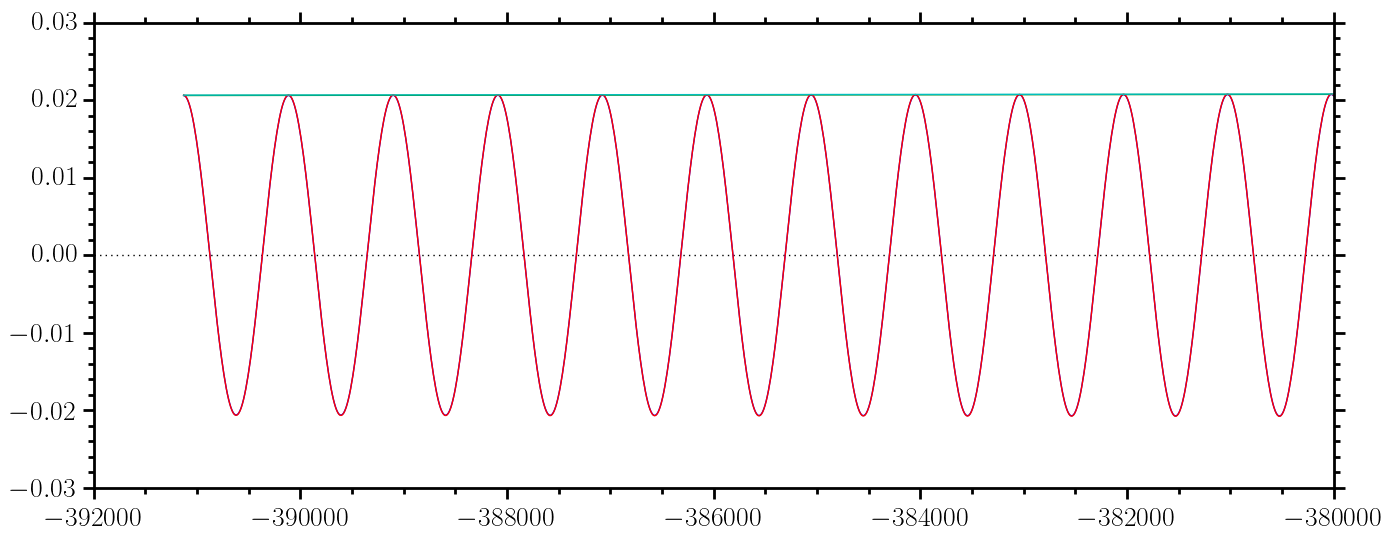

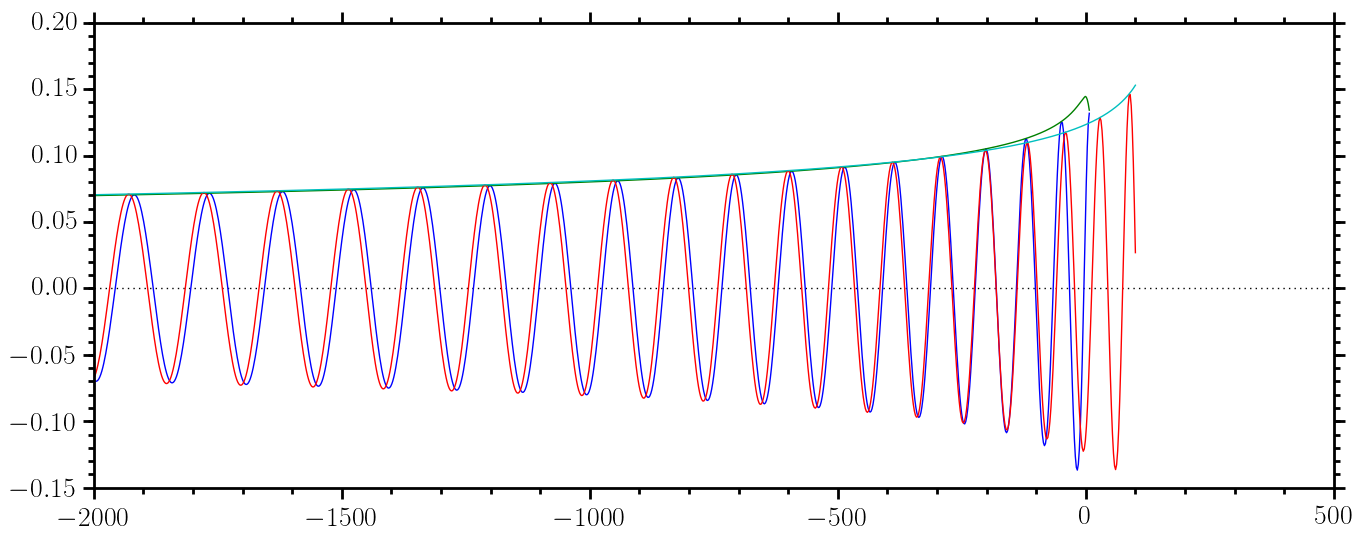

In [167]:
fig, axes = plt.subplots(1, figsize=(16, 6))
plot_waveforms(axes, [hrom, ht4_comp], -400000, -380000, npoints=1000)
axes.minorticks_on()

fig, axes = plt.subplots(1, figsize=(16, 6))
plot_waveforms(axes, [hrom, ht4_comp], -2000, 100, npoints=1000)
axes.minorticks_on()

(-10000, 2000)

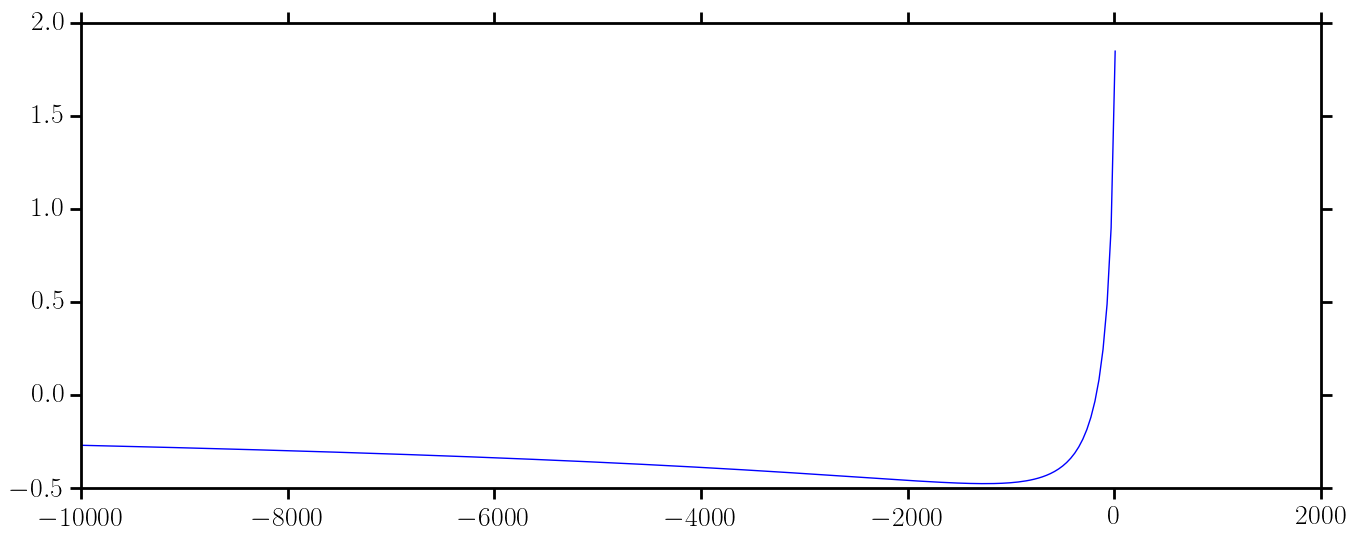

In [180]:
dphase = subtract_waveform_phase(hrom, ht4_comp, npoints=10000)

fig, axes = plt.subplots(1, figsize=(16, 6))
axes.plot(dphase.x, dphase.phase)
axes.set_xlim(-10000, 2000)

In [94]:
# def time_to_frequency_waveform(h, dt, N, df):
#     """Fourier transform of Waveform h.
#     """
#     # Make new waveform with t=0 at beginning
#     hshift = h.copy()
#     hshift.add_x(-h.data['x'][0])
    
#     # Interpolate and sample at desired times
#     # End is padded with zeros
#     hcompint = hshift.interpolate_complex()
#     times = np.arange(0, hshift.data['x'][-1], dt)
#     Ntimes = len(times)
#     if Ntimes > N:
#         raise Exception, 'N must be greater than the number of samples Ntimes = '+str(Ntimes)
        
#     # Evaluate complex waveform at uniformly sampled times and pad the end with zeros 
#     hcomp = np.zeros(N, dtype=complex)
#     hcomp[:Ntimes] = hcompint(times)
    
#     # Sign convention is opposite of LSC, so use IFFT instead of FFT.
#     htilde = dt*np.fft.fft(hcomp)
#     freqs = np.arange(N)/float(N*dt)
    
#     htilde_wave = Waveform.from_hp_hc(freqs, np.real(htilde), np.imag(htilde))
    
#     f_down = np.arange(0, freqs[-1], df)
#     ampoff = htilde_wave.interpolate('amp')
#     phaseoff = htilde_wave.interpolate('phase')
    
#     amp_down = ampoff(f_down)
#     phase_down = phaseoff(f_down)
    
#     #!!! You probably also have to do a time and phase shift so that you align at max amp
# #     tstart = h.data['x'][0]
# #     tshift = 2*np.pi*tstart*f_down
# #     phase_down += tshift
    
#     # !!! You should remove half the data and only go up to Nyquist frequency !!! 
#     return Waveform.from_amp_phase(f_down, amp_down, phase_down)

In [253]:
#!!! You might also want an option to do a time shift so that of start at the original time
#     tstart = h.data['x'][0]
#     tshift = 2*np.pi*tstart*f_down    

# You might also want to remove frequencies above the Nyquist frequency

def time_to_frequency_waveform(h, dt, npoints=None, df=None):
    """Fourier transform of Waveform h.
    The product dt*npoints should be >= the length of h if you don't want h to be truncated.
    
    Parameters
    ----------
    h : Waveform
    dt : float
        Resample the waveform with times dt
    npoints : int, optional
        Number of resampled points starting at beginning of waveform.
        Truncates waveform or pads the end with zeros if necessary.
    """    
    # Determine number of points if necessary
    # int rounds down (needed so that your last point does not go past the end of the waveform)
    if npoints is None:
        npoints = int((h.x[-1] - h.x[0]) / dt)
    
    # Find times to resample the waveform at
    # Making sure you don't go past the end of the waveform
    nresamp = min(npoints, len(h.x))
    times = np.array([h.x[0]+i*dt for i in range(nresamp)])
        
    # Create interpolating function and resample at desired times
    hcompint = h.interpolate_complex()(times)
    hresamp = np.zeros(npoints, dtype=complex)
    hresamp[:nresamp] = hcompint
    
    print hresamp
    print len(hresamp)
    
    # Do the FFT and store the result in a Waveform object
    htilde = dt*np.fft.fft(hresamp)
    freqs = np.arange(npoints)/float(npoints*dt)
    htilde_wave = Waveform.from_complex(freqs, htilde)
    
    # Resample the Fourier transformed waveform if requested
    if df is None:
        return htilde_wave
    else:
        fresamp = np.arange(0, freqs[-1], df)
        ampoff = htilde_wave.interpolate('amp')(fresamp)
        phaseoff = htilde_wave.interpolate('phase')(fresamp)
        return Waveform.from_amp_phase(fresamp, ampoff, phaseoff)
 

In [222]:
# ht4test = Waveform.from_complex(np.array(ht4p.sample_times), np.array(ht4p)+1.0j*np.array(ht4c))
# dt = ht4p.delta_t
# N = len(ht4p)
# df = ht4p_tilde.delta_f
# ht4test_tilde = time_to_frequency_waveform(ht4test, dt, N, df)
# hromphys_tilde = time_to_frequency_waveform(hromphys, dt, N, df)

In [266]:
ht4_comp_phys = Waveform.from_hp_hc(np.array(ht4p.sample_times), np.array(ht4p), np.array(ht4c))
dt = ht4p.delta_t
npoints = len(ht4p)
#ht4test_tilde = time_to_frequency_waveform(ht4_comp_phys, dt, npoints=npoints)
ht4test_tilde = time_to_frequency_waveform(ht4_comp_phys, dt)

[ -1.97174434e-23 -1.41437851e-24j  -1.96487936e-23 -2.16932524e-24j
  -1.95512481e-23 -2.92109215e-24j ...,  -1.59143175e-23 -1.45505325e-22j
   9.23548240e-23 -1.18426412e-22j   1.53785557e-22 -1.67698305e-23j]
63147


In [267]:
len(ht4test_tilde.x), len(ht4test_tilde.amp), len(ht4test_tilde.phase)

(63147, 63147, 63147)

In [268]:
def plot_waveforms_freq(axes, waveforms, xi, xf, npoints=1000):
    axes.axhline(0.0, color='k', ls=':')
    
    for h in waveforms:
        xiplot = max(xi, h.x[0])
        xfplot = min(xf, h.x[-1])
        hcomp = h.interpolate_complex()
        times = np.linspace(xiplot, xfplot, npoints)
        hs = hcomp(times)
        
        axes.plot(times, np.real(hs))
        axes.plot(times, np.abs(hs))

In [269]:
ht4p_tilde.sample_frequencies[-1]

8192.0

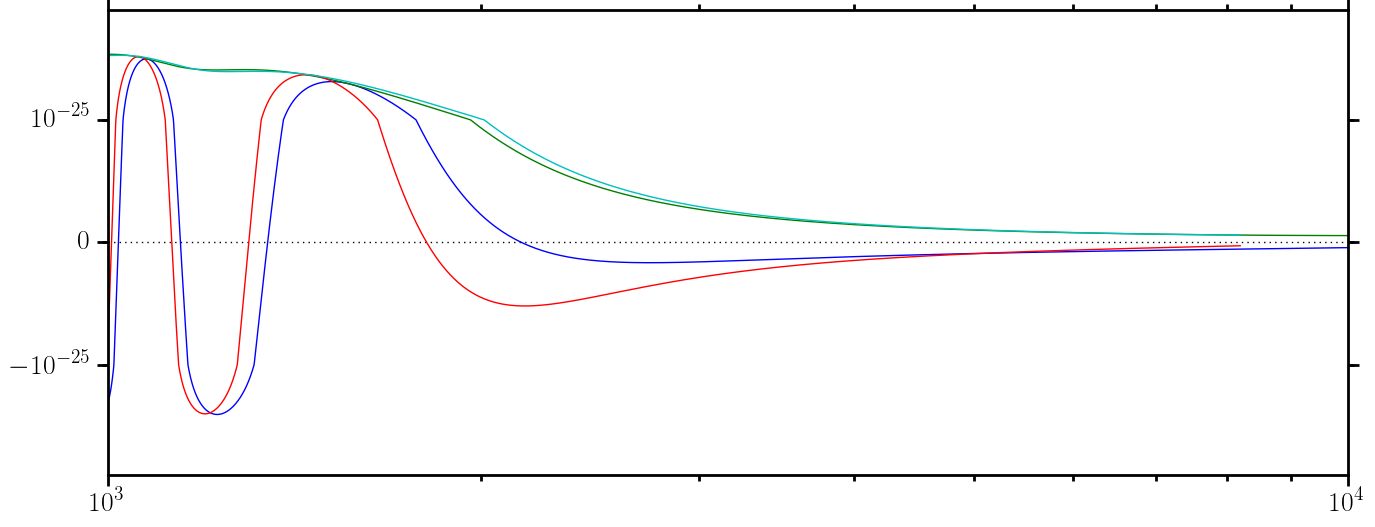

In [270]:
fig, axes = plt.subplots(1, figsize=(16, 6))
plot_waveforms_freq(axes, [ht4test_tilde, ht4_tilde], 1000, 10000, npoints=10000)
axes.set_xscale('log')
axes.set_yscale('symlog', linthreshy=1.0e-25)
#axes.yaxis.set_minor_locator(MinorSymLogLocator(1.0e-25))
#axes.set_ylim(10.0, 1.0e5)

(10.0, 100000.0)

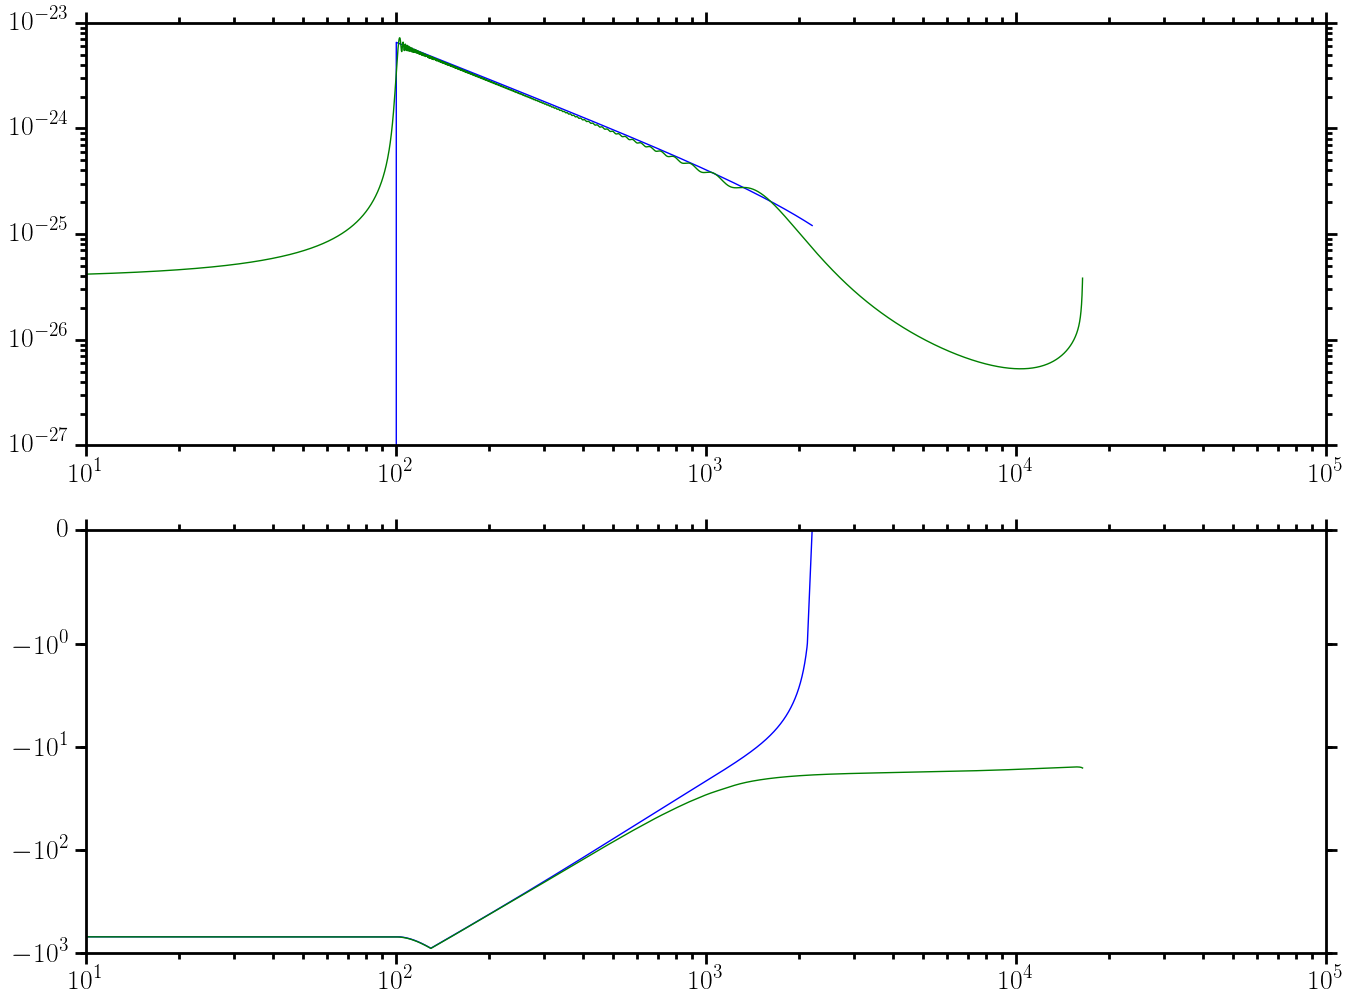

In [239]:
fig, ax = plt.subplots(2, figsize=(16, 12))

ax[0].plot(hf2_tilde.x, hf2_tilde.amp)
ax[0].plot(ht4test_tilde.x, ht4test_tilde.amp)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].minorticks_on()
ax[0].set_xlim(10.0, 1.0e5)

ax[1].plot(hf2_tilde.x, hf2_tilde.phase-hf2_tilde.phase[-1])
ax[1].plot(ht4test_tilde.x, ht4test_tilde.phase-hf2_tilde.phase[-1])
ax[1].set_xscale('log')
ax[1].set_yscale('symlog', linthreshy=1.0)
ax[1].set_xlim(10.0, 1.0e5)

(10.0, 100000.0)

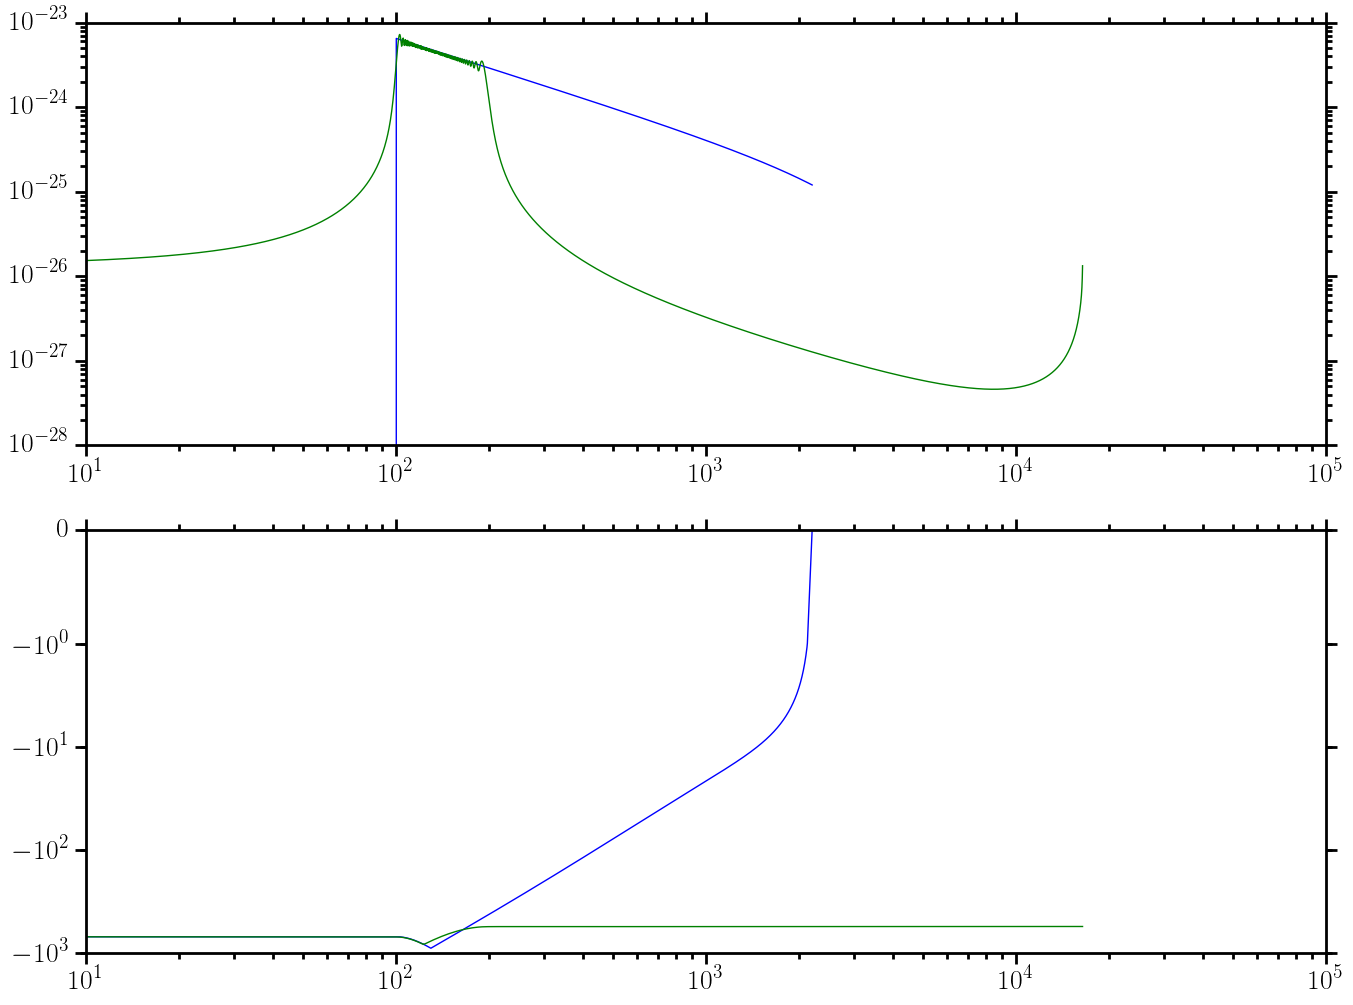

In [231]:
fig, ax = plt.subplots(2, figsize=(16, 12))

ax[0].plot(hf2_tilde.x, hf2_tilde.amp)
ax[0].plot(ht4test_tilde.x, ht4test_tilde.amp)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].minorticks_on()
ax[0].set_xlim(10.0, 1.0e5)

ax[1].plot(hf2_tilde.x, hf2_tilde.phase-hf2_tilde.phase[-1])
ax[1].plot(ht4test_tilde.x, ht4test_tilde.phase-hf2_tilde.phase[-1])
ax[1].set_xscale('log')
ax[1].set_yscale('symlog', linthreshy=1.0)
ax[1].set_xlim(10.0, 1.0e5)

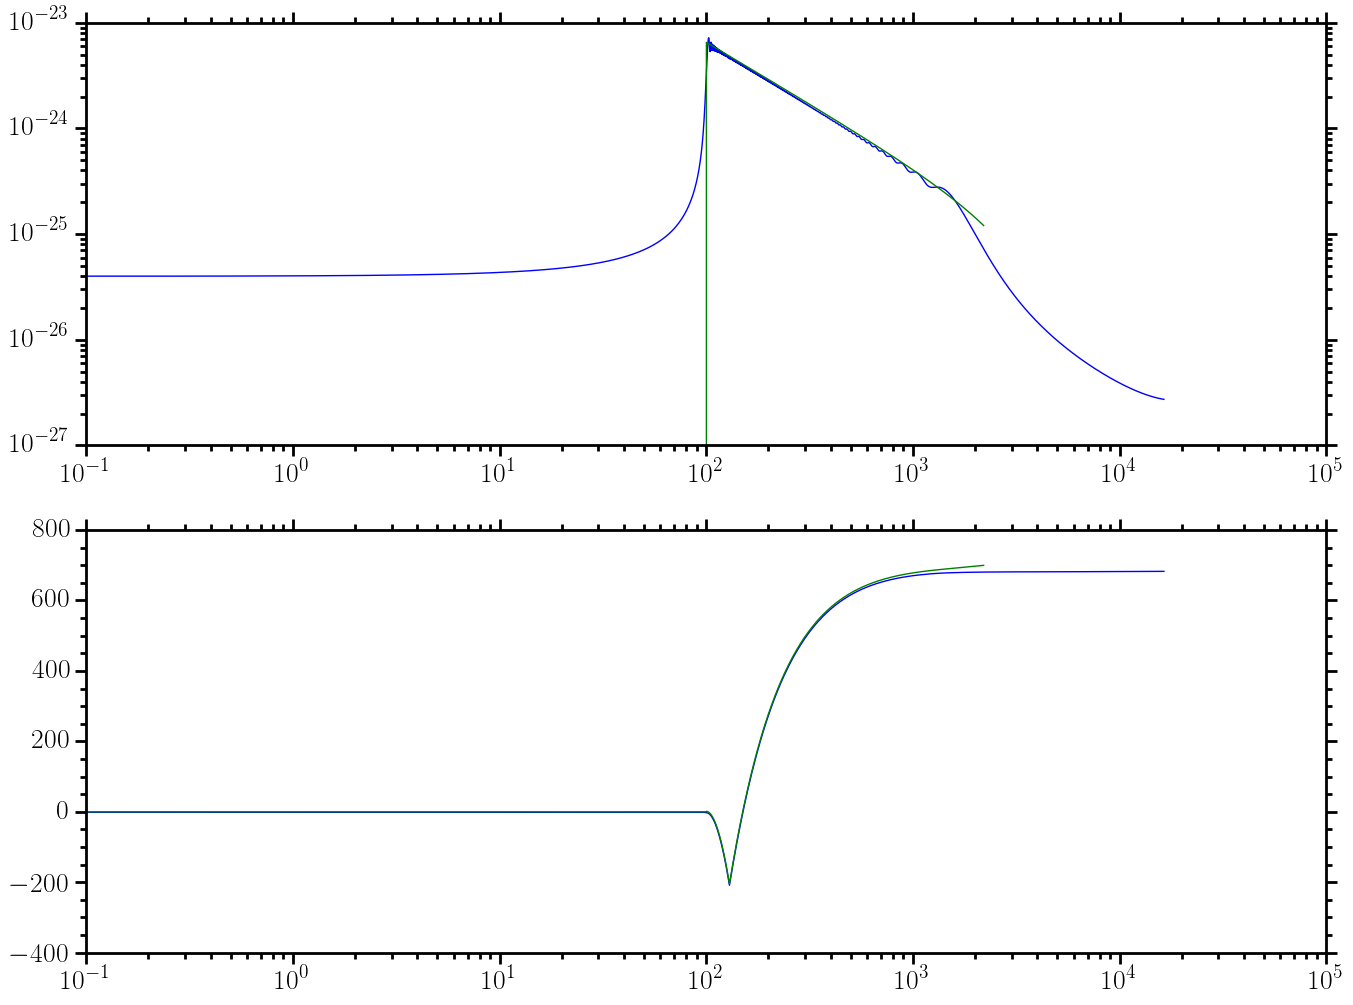

In [93]:
fig, ax = plt.subplots(2, figsize=(16, 12))

ax[0].plot(ht4_tilde.x, ht4_tilde.amp)
ax[0].plot(hf2_tilde.x, hf2_tilde.amp)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].minorticks_on()
ax[0].set_xlim(10.0, 1.0e5)
ax[0].set_ylim(1.0e-26, 1.0e-23)

ax[1].plot(ht4_tilde.x, ht4_tilde.phase)
ax[1].plot(hf2_tilde.x, hf2_tilde.phase)
ax[1].set_xscale('log')
ax[1].minorticks_on()
#ax[1].set_ylim(-1000, 15000)
#ax[1].set_xlim(1.0e-5, 0.2)

In [206]:
#hhybridwin = hhybrid.copy()
hhybridwin = window_waveform(hhybrid, hhybrid.x[0]+200000., hhybrid.x[-1]-500.)
hhybridphys = dimensionless_to_physical_time(hhybridwin, mass1+mass2, distance)
hhybridphys_tilde = time_to_frequency_waveform(hhybridphys, dt, N, df)

Exception: N must be greater than the number of samples Ntimes = 127017

(10.0, 100000.0)

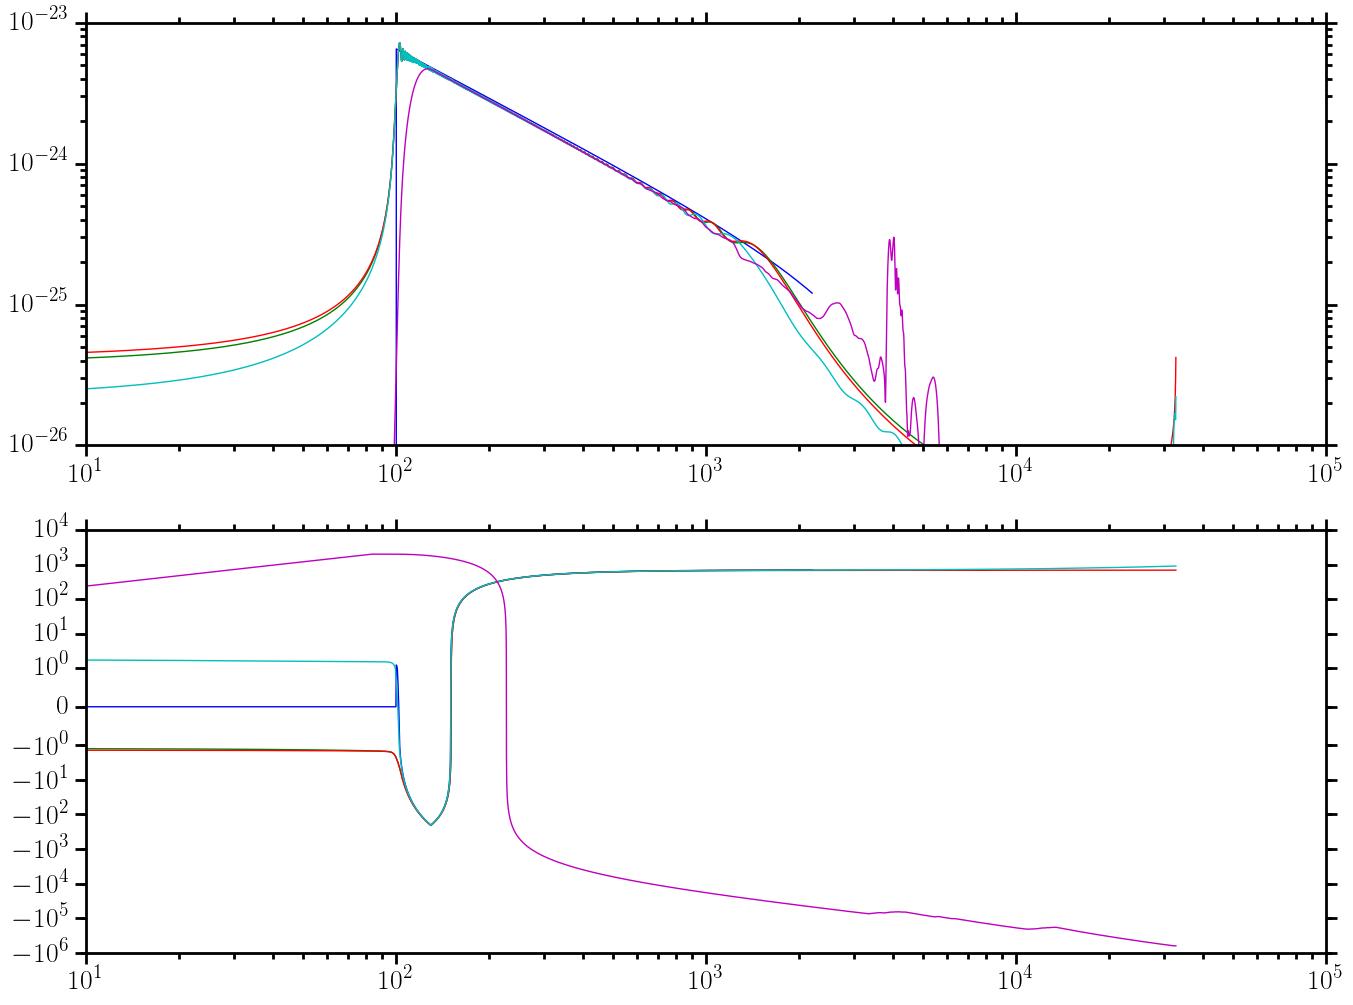

In [204]:
fig, ax = plt.subplots(2, figsize=(16, 12))

ax[0].plot(hf2_tilde.x, hf2_tilde.amp)
ax[0].plot(ht4_tilde.x, ht4_tilde.amp)
ax[0].plot(ht4test_tilde.x, ht4test_tilde.amp)
ax[0].plot(hromphys_tilde.x, hromphys_tilde.amp)
ax[0].plot(hhybridphys_tilde.x, hhybridphys_tilde.amp)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].minorticks_on()
ax[0].set_xlim(10.0, 1.0e5)
ax[0].set_ylim(1.0e-26, 1.0e-23)

ax[1].plot(hf2_tilde.x, hf2_tilde.phase)
ax[1].plot(ht4_tilde.x, ht4_tilde.phase)
ax[1].plot(ht4test_tilde.x, ht4test_tilde.phase)
ax[1].plot(hromphys_tilde.x, hromphys_tilde.phase)
ax[1].plot(hhybridphys_tilde.x, hhybridphys_tilde.phase)
ax[1].set_xscale('log')
ax[1].set_yscale('symlog', linthreshy=1.0)
#ax[1].minorticks_on()
ax[1].set_xlim(10.0, 1.0e5)
#ax[1].set_ylim(-5.0e4, 1.0e4)

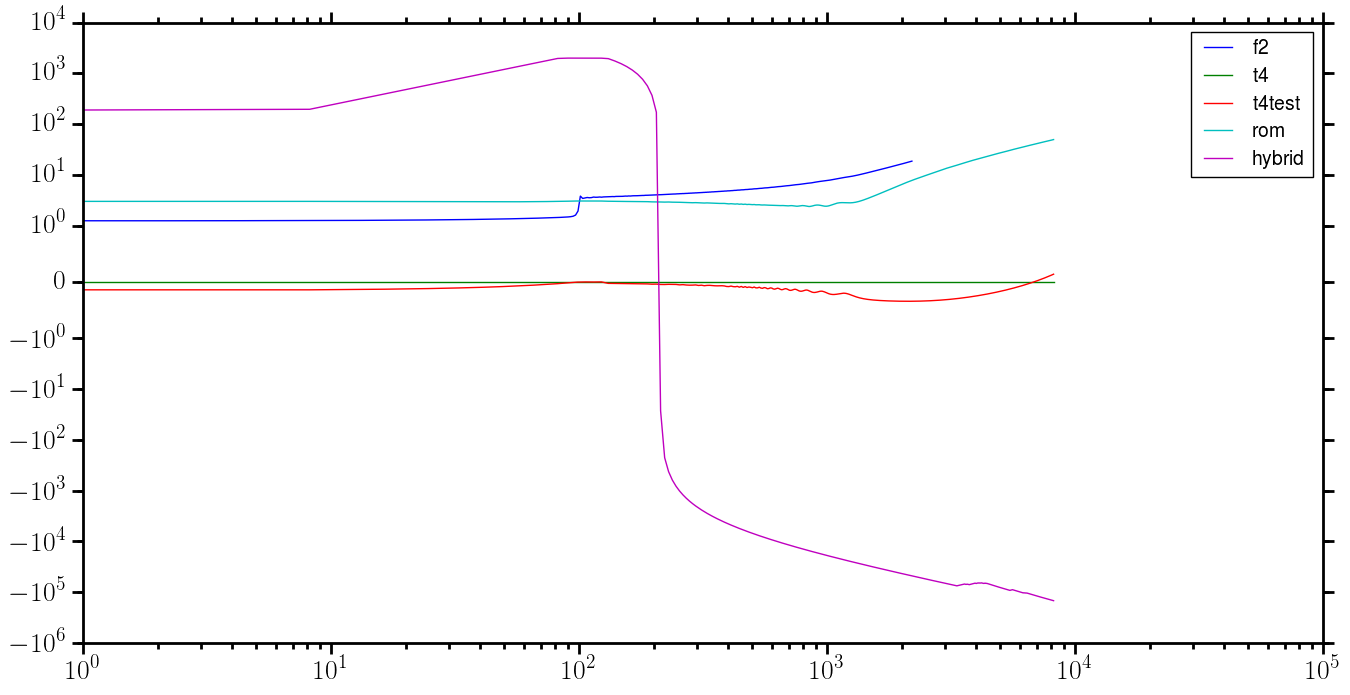

In [203]:
fig, ax = plt.subplots(1, figsize=(16, 8))
dphase = subtract_waveform_phase(hf2_tilde, ht4_tilde, npoints=1000)
ax.plot(dphase.x, dphase.phase, label='f2')

dphase = subtract_waveform_phase(ht4_tilde, ht4_tilde, npoints=1000)
ax.plot(dphase.x, dphase.phase, label='t4')

dphase = subtract_waveform_phase(ht4test_tilde, ht4_tilde, npoints=1000)
ax.plot(dphase.x, dphase.phase, label='t4test')

dphase = subtract_waveform_phase(hromphys_tilde, ht4_tilde, npoints=1000)
ax.plot(dphase.x, dphase.phase, label='rom')

dphase = subtract_waveform_phase(hhybridphys_tilde, ht4_tilde, npoints=1000)
ax.plot(dphase.x, dphase.phase, label='hybrid')
ax.set_xscale('log')
ax.set_yscale('symlog', linthreshy=1.0)
#ax.minorticks_on()
ax.set_xlim(1.0, 1.0e5)
#ax.set_ylim(-12000, 12000)
ax.legend()

# Make functions for windowing and resampling uniformly in phase

In [ ]:
# Function for windowing time-domain waveform between two frequencies:
# Calculate time of each frequency, then window.

In [98]:
# Add option to choose starting frequency (dx/dt/2pi) instead of starting x
# Default should be first and last data point, so no windowing is done if not specified
def window_waveform(h, xon_end, xoff_start):
    """Take two waveforms that have already been aligned in time and phase
    and smoothly transition from h1 to h2 over the window [wi, wf].
    """
    
    
    def winoff(t, wi, wf):
        return 0.5*(1.0 + np.cos( (np.pi*(t-wi))/(wf-wi) ) )
    
    def winon(t, wi, wf):
        return 0.5*(1.0 - np.cos( (np.pi*(t-wi))/(wf-wi) ) )
    
    # searchsorted finds index of (sorted) time where point should be inserted,
    # pushing the later points to the right.
    # indices will be just to the right of the boundaries [wi, wf]:
    ion_end = np.searchsorted(h.x, xon_end)
    ioff_start = np.searchsorted(h.x, xoff_start)
    
    # Times (window on, middle, wondow off)
    xson = h.x[:ion_end]
    xsoff = h.x[ioff_start:]
    
    hwin = h.copy()
    hwin.amp[:ion_end] *= winon(xson, hwin.x[0], xon_end)
    hwin.amp[ioff_start:] *= winoff(xsoff, xoff_start, hwin.x[-1])
    
    return hwin

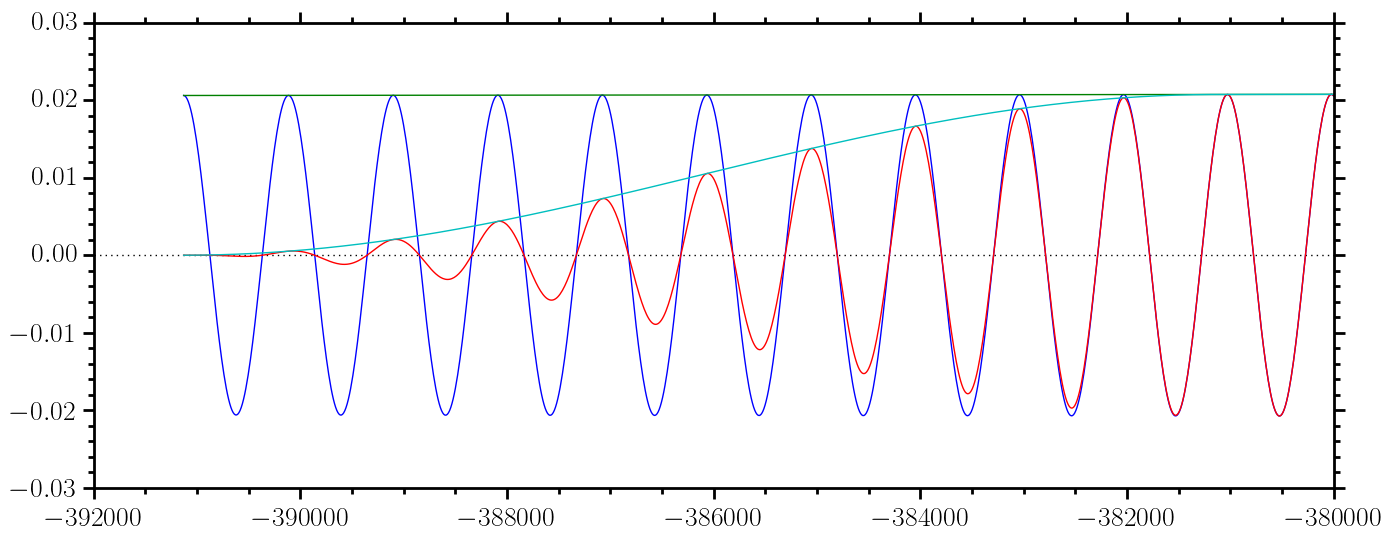

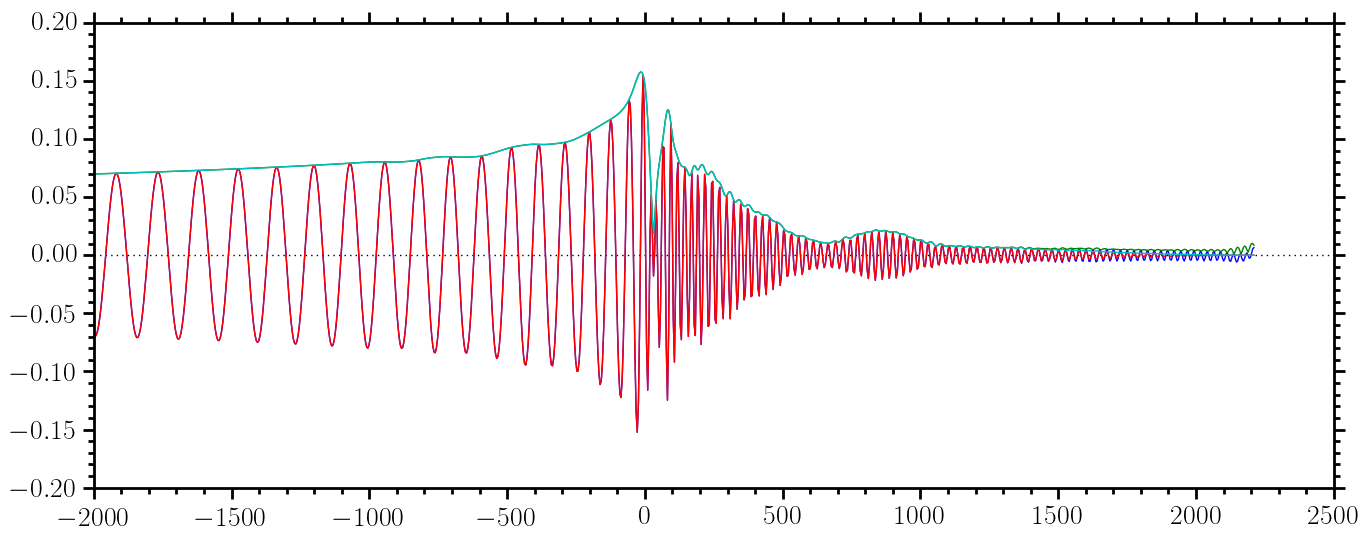

In [106]:
hhybridwin = window_waveform(hhybrid, hhybrid.x[0]+10000., hhybrid.x[-1]-1000.)

fig, axes = plt.subplots(1, figsize=(16, 6))
plot_waveforms(axes, [hhybrid, hhybridwin], -400000, -380000, npoints=1000)
axes.minorticks_on()

fig, axes = plt.subplots(1, figsize=(16, 6))
plot_waveforms(axes, [hhybrid, hhybridwin], -2000, 4000, npoints=1000)
axes.minorticks_on()

In [ ]:
#     def to_frequencyseries(self, delta_f=None):
#         """ Return the Fourier transform of this time series
        
#         Parameters
#         ----------
#         delta_f : {None, float}, optional
#             The frequency resolution of the returned frequency series. By 
#         default the resolution is determined by the duration of the timeseries.
        
#         Returns
#         -------        
#         FrequencySeries: 
#             The fourier transform of this time series. 
#         """
#         from pycbc.fft import fft
#         if not delta_f:
#             delta_f = 1.0 / self.duration

#         # add 0.5 to round integer
#         tlen  = int(1.0 / delta_f / self.delta_t + 0.5)
#         flen = tlen / 2 + 1

#         if tlen < len(self):
#             raise ValueError("The value of delta_f (%s) would be "
#                              "undersampled. Maximum delta_f "
#                              "is %s." % (delta_f, 1.0 / self.duration))
#         if not delta_f:
#             tmp = self
#         else:
#             tmp = TimeSeries(zeros(tlen, dtype=self.dtype), 
#                              delta_t=self.delta_t, epoch=self.start_time)
#             tmp[:len(self)] = self[:]
        
#         f = FrequencySeries(zeros(flen, 
#                            dtype=complex_same_precision_as(self)),
#                            delta_f=delta_f)
#         fft(tmp, f)
#         return f